# Polar Vantage V2: Guide to data extraction and analysis

<img src='https://i.imgur.com/xqJvlna.jpeg' height="500"> 

A picture of the Polar Mobile Application

Where do polar bears go to vote? <br>The North Pole.

In this notebook, we would definitely not be visiting the North Pole to watch Polar bears vote. Instead, we will be using the [Polar Vantage V2](https://www.polar.com/en/vantage/v2) which is a smart watch designed for carefully monitoring the most important muscle in your body -- your body. The watch is equipped with advanced wrist-based HR tracking, GPS, ultra-long battery life, running & cycling performance tests, FuelWise, route guidance, sleep tracking, & more. The Vantage V2 can also be utlized to record more than 130 popular sports. It also has an app that you can utilize to view reports on your data.

This is a comprehensive, clear guide to extract your data from the Polar Flow App using the Wearipedia package.

We will be able to extract the following parameters:

Parameter Name  | Sampling Frequency 
-------------------|-----------------
Heart Rate |  Every 5 minutes
Heart Rate Variability |  Every 5 minutes
Breathing Rate |  Every 5 minutes
Hypnogram |  For every change detected in sleeping phase 
Calories |  Per Activity
Average and Maximum Heart Rate |  Per Activity
Light Sleep Duration | Per Night
Deep Sleep Duration | Per Night
Interruption Duration | Per Night
REM Duration | Per Night
<b>Sleep Score</b> | Per Night
<b>Sleep Duration</b> | Per Night
<b>Sleep Cycles Count</b> | Per Night
Sleep Regeneration Score | Per Night
Beat to Beat Average | Per Night
Heart Rate Variability Average | Per Night
Breathing Rate Average | Per Night
<b>Heart Rate Average</b> | Per Night

** These datatypes are all subsets of sleep and training history.

In this guide, we sequentially cover the following **nine** topics to extract data from Cronometer servers:

1. **Setup**<br>
2. **Authentication and Authorization**<br>
   - Requires only username and password, no OAuth.<br>
3. **Data Extraction**<br>
  - We get data via wearipedia in a couple lines of code<br>
4. **Data Exporting**
    - We export all of this data to file formats compatible by R, Excel, and MatLab.
5. **Adherence**
    - We simulate non-adherence by dynamically removing datapoints from our simulated data.
6. **Visualization**
    - We create a simple plot to visualize our data.
7. **Advanced Visualization**
    - 7.1 Visualizing Participants Heart Rate during Sleep! <br>
    - 7.2 Visualizing Participants Sleep Breakdown!<br>
    - 7.3 Visualizing Weekly Sleep Summary!<br>
8. **Data Analysis and Data Cleaning** <br>
  - 8.1  Analyzing correlation between Sleep Phase and Heart Rate! <br>
9. **Outlier Detection** <br>
  - 9.1 Highlighting Outliers!

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own email and password on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

# 1. Setup

## Participant Setup

Dear Participant,

Once you download the polar flow app, please set it up by following these resources:
- Written guide: https://flow.polar.com/start
- Video guide: https://www.youtube.com/watch?v=INEeXT8FC9I

Make sure that your phone is logged to the polar flow app using the Polar login credentials (email and password) given to you by the data receiver.

Best,

Wearipedia

## Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`.
2. Create a Polar account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Request the participant to download the app and instruct them to follow the participant setup letter above.
5. Install the `wearipedia` Python package to easily extract data from this device via the Polar API.


In [1]:
!pip install wearipedia
!pip install openpyxl

In [2]:
import wearipedia
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from scipy import stats
from sklearn.covariance import EllipticEnvelope
import copy

# 2. Authentication and Authorization

To obtain access to data, authorization is required. All you'll need to do here is just put in your email and password for your Polar account. We'll use this username and password to extract the data in the sections below.

In [3]:
#@title Enter Cronometer login credentials
email_address = "test@stanford.edu" #@param {type:"string"}
password = "putyourpasswordhere" #@param {type:"string"}

# 3. Data Extraction

Data can be extracted via [wearipedia](https://github.com/Stanford-Health/wearipedia/), our open-source Python package that unifies dozens of complex wearable device APIs into one simple, common interface.

First, we'll set a date range and then extract all of the data within that date range. You can select whether you would like synthetic data or not with the checkbox.

In [4]:
#@title Enter start and end dates (in the format yyyy-mm-dd)

#set start and end dates - this will give you all the data from 2000-01-01 (January 1st, 2000) to 2100-02-03 (February 3rd, 2100), for example
start_date='2022-01-01' #@param {type:"string"}
end_date='2022-08-28' #@param {type:"string"}
synthetic = True #@param {type:"boolean"}

In [5]:
device = wearipedia.get_device("polar/vantage")

if not synthetic:
    device.authenticate({"email": email_address, "password": password})

params = {"start_date": start_date, "end_date": end_date, 'training_id':'7472390363'}

Let's first extract the sleep data and plot the head of the dataframe

In [6]:
sleep = device.get_data("sleep", params=params)
pd.DataFrame(sleep).head()

,date,sleepStartTime,sleepEndTime,sleepStartOffset,sleepEndOffset,sleepRating,continuityIndex,continuityClass,sleepCycles,sleepScore,sleepWakeStates
0,2022-04-20,2022-04-20T20:11:36.977-17:57,2022-04-21T08:07:40.398-06:43,0,0,None,1.2,1,6,3.29380,"[{'sleepWakeState': 2, 'offsetFromStart': 0, '..."
1,2022-04-21,2022-04-21T22:08:42.705-19:48,2022-04-22T09:36:10.994-04:53,0,0,None,0.8,1,6,79.20229,"[{'sleepWakeState': 0, 'offsetFromStart': 0, '..."
2,2022-04-22,2022-04-22T23:21:14.029-16:27,2022-04-23T08:45:27.545-05:26,0,0,None,0.8,1,5,4.06915,"[{'sleepWakeState': 2, 'offsetFromStart': 0, '..."
3,2022-04-23,2022-04-23T21:40:00.700-15:47,2022-04-24T07:23:09.021-06:42,0,0,None,0.1,1,6,77.81433,"[{'sleepWakeState': 3, 'offsetFromStart': 0, '..."
4,2022-04-24,2022-04-24T21:53:27.317-19:39,2022-04-25T08:34:39.543-05:01,0,0,None,1.8,1,6,63.99695,"[{'sleepWakeState': 2, 'offsetFromStart': 0, '..."


Next, let's plot the training history

In [7]:
training_history = device.get_data("training_history", params=params)
pd.DataFrame(training_history).head()

,id,duration,distance,hrAvg,calories,note,sportName,sportId,startDate,recoveryTime,iconUrl,trainingLoadHtml,hasTrainingTarget,swimmingSport,swimmingPoolUnits,trainingLoadProHtml,periodDataUuid,isTest
0,5159093520,1684330,1403,169,140,,Cycling,16,2022-04-20 12:37:32.337,671975,https://platform.cdn.polar.com/ecosystem/sport...,,False,True,METERS,000000,84fc493d-c482-4f16-a5e2-d44cc43f9edd,False
1,4717750100,5066145,4221,149,422,,Running,15,2022-04-21 07:34:48.656,4840507,https://platform.cdn.polar.com/ecosystem/sport...,,False,False,METERS,000000,84fc493d-c482-4f16-a5e2-d44cc43f9edd,False
2,9116079484,7054147,5878,179,587,,Running,15,2022-04-22 07:17:09.213,5848324,https://platform.cdn.polar.com/ecosystem/sport...,,False,False,METERS,000000,84fc493d-c482-4f16-a5e2-d44cc43f9edd,False
3,2376114721,6305314,5254,114,525,,Running,2,2022-04-23 18:52:10.626,3796317,https://platform.cdn.polar.com/ecosystem/sport...,,False,False,METERS,000000,84fc493d-c482-4f16-a5e2-d44cc43f9edd,False
4,4350313699,5647318,4706,98,470,,Strength_Training,1,2022-04-24 06:48:29.708,645180,https://platform.cdn.polar.com/ecosystem/sport...,,False,False,METERS,000000,84fc493d-c482-4f16-a5e2-d44cc43f9edd,False


Lastly, using wearipedia we can also extract this training by id.

In [8]:
training_by_id = device.get_data("training_by_id", params=params)
pd.DataFrame(training_by_id).head()

""


# 4. Data Exporting

In this section, we export all of this data to formats compatible with popular scientific computing software (R, Excel, Google Sheets, Matlab). Specifically, we will first export to JSON, which can be read by R and Matlab. Then, we will export to CSV, which can be consumed by Excel, Google Sheets, and every other popular programming language.

## Exporting to JSON (R, Matlab, etc.)

Exporting to JSON is fairly simple. We export each datatype separately and also export a complete version that includes all simultaneously.

In [9]:
training_history

[{'id': 5159093520,
  'duration': 1684330,
  'distance': 1403,
  'hrAvg': 169,
  'calories': 140,
  'note': ' ',
  'sportName': 'Cycling',
  'sportId': 16,
  'startDate': '2022-04-20 12:37:32.337',
  'recoveryTime': 671975,
  'iconUrl': 'https://platform.cdn.polar.com/ecosystem/sport/icon/561a80f6d7eef7cc328aa07fe992af8e-2015-10-20_13_46_03',
  'trainingLoadHtml': '',
  'hasTrainingTarget': False,
  'swimmingSport': True,
  'swimmingPoolUnits': 'METERS',
  'trainingLoadProHtml': '000000',
  'periodDataUuid': '84fc493d-c482-4f16-a5e2-d44cc43f9edd',
  'isTest': False},
 {'id': 4717750100,
  'duration': 5066145,
  'distance': 4221,
  'hrAvg': 149,
  'calories': 422,
  'note': ' ',
  'sportName': 'Running',
  'sportId': 15,
  'startDate': '2022-04-21 07:34:48.656',
  'recoveryTime': 4840507,
  'iconUrl': 'https://platform.cdn.polar.com/ecosystem/sport/icon/808d0882e97375e68844ec6c5417ea33-2015-10-20_13_46_22',
  'trainingLoadHtml': '',
  'hasTrainingTarget': False,
  'swimmingSport': False

In [10]:
# Convert int64 values to regular Python integers
for value in training_history:
    for key in value:
        if isinstance(value[key], np.int64):
            value[key] = int(value[key])

json.dump(sleep, open("sleep.json", "w"))
json.dump(training_history, open("training_history.json", "w"))
json.dump(training_by_id, open("training_by_id.json", "w"))

complete = {
    "sleep": sleep,
    "training_history": training_history,
    "training_by_id": training_by_id
}

json.dump(complete, open("complete.json", "w"))

Feel free to open the file viewer (see left pane) to look at the outputs!

## Exporting to CSV and XLSX (Excel, Google Sheets, R, Matlab, etc.)

Exporting to CSV/XLSX requires a bit more processing, since they enforce a pretty restrictive schema.

We will thus export steps, heart rates, and breath rates all as separate files.

In [11]:
sleep_df = pd.DataFrame.from_dict(sleep)

sleep_df.to_csv('sleep.csv')
sleep_df.to_excel('sleep.xlsx')

training_history_df = pd.DataFrame.from_dict(training_history)

training_history_df.to_csv('training_history.csv', index=False)
training_history_df.to_excel('training_history.xlsx', index=False)

training_by_id_df = pd.DataFrame.from_dict(training_by_id)

training_by_id_df.to_csv('exercises.csv', index=False)
training_by_id_df.to_excel('exercises.xlsx', index=False)


Again, feel free to look at the output files and download them.

# 5. Adherence

The device simulator already automatically randomly deletes small chunks of the day. In this section, we will simulate non-adherence over longer periods of time from the participant (day-level and week-level).

Then, we will detect this non-adherence and give a Pandas DataFrame that concisely describes when the participant has had their device on and off throughout the entirety of the time period, allowing you to calculate how long they've had it on/off etc.

We will first delete a certain % of blocks either at the day level or week level, with user input.

In [12]:
#@title Non-adherence simulation
block_level = "day" #@param ["day", "week"]
adherence_percent = 0.89 #@param {type:"slider", min:0, max:1, step:0.01}

In [13]:
import numpy as np

if block_level == "day":
    block_length = 1
elif block_level == "week":
    block_length = 7



# This function will randomly remove datapoints from the 
# data we have recieved from Polar Flow based on the
# adherence_percent

def AdherenceSimulator(data):

    num_blocks = len(data) // block_length
    num_blocks_to_keep = int(adherence_percent * num_blocks)
    idxes = np.random.choice(np.arange(num_blocks), replace=False, 
        size=num_blocks_to_keep)

    adhered_data = []

    for i in range(len(data)):
        if i in idxes:
            start = i * block_length
            end = (i + 1) * block_length
            for j in range(i,i+1):
                adhered_data.append(data[j])

    return adhered_data


# Adding adherence for sleep

sleep = AdherenceSimulator(sleep)

# Adding adherence for exercises

training_history = AdherenceSimulator(training_history)

And now we have significantly fewer datapoints! This will give us a more realistic situation, where participants may take off their device for days or weeks at a time.

Now let's detect non-adherence. We will return a Pandas DataFrame sampled at every day.

In [14]:
sleep_df = pd.DataFrame.from_dict(sleep)
training_history_df = pd.DataFrame.from_dict(training_history)

We can plot this out, and we get adherence at one-day frequency throughout the entirety of the data collection period. For this chart we will plot Energy consumed over the time period from the dailySummary dataframe.

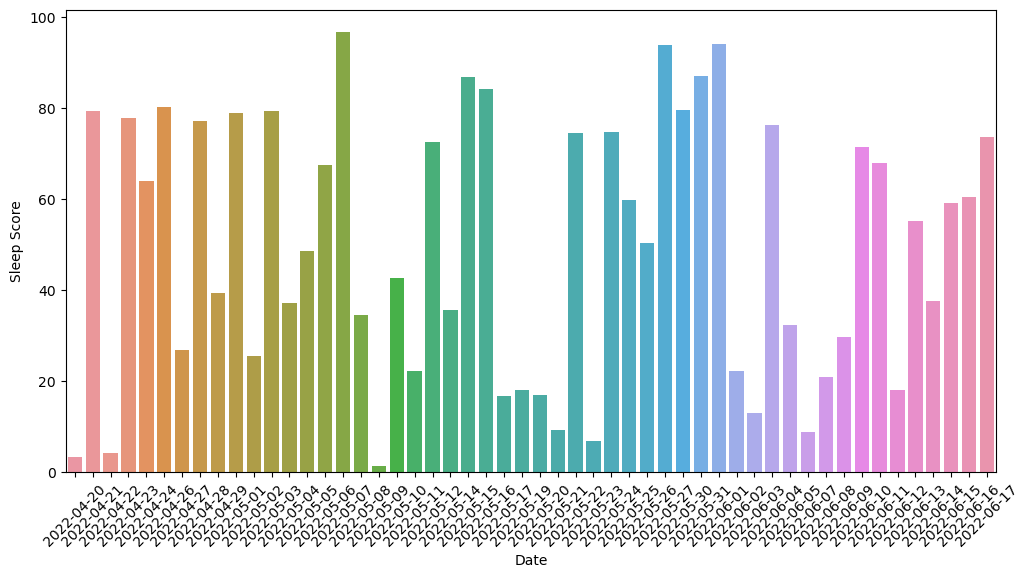

In [15]:
plt.figure(figsize=(12, 6))
sns.barplot(x=sleep_df.date, y=sleep_df.sleepScore)
plt.ylabel('Sleep Score')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

# 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our three kinds of data in a simple, customizable plot! This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics.

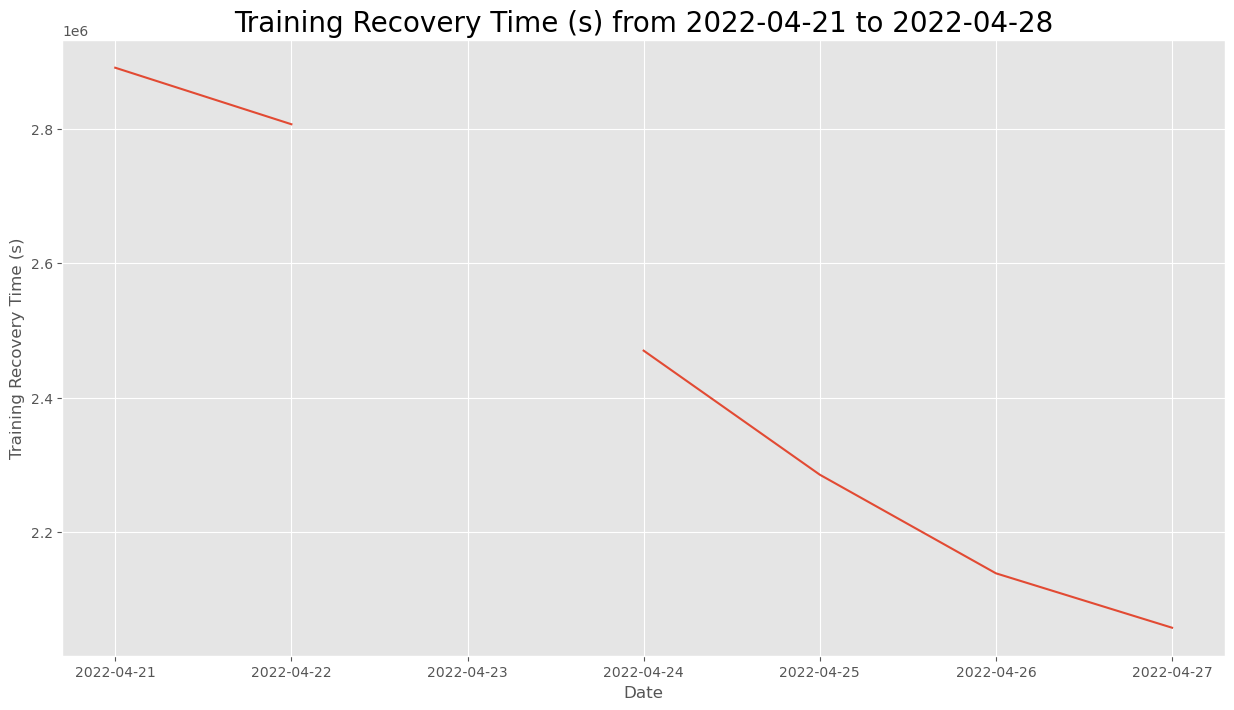

In [36]:
#@title Basic Plot
feature = "Training Recovery Time" #@param ['Training Calories', 'Training Average Heart Rate','Training Distance','Training Recovery Time']
start_date = "2022-04-21" #@param {type:"date"}
time_interval = "one week" #@param ["one week", "full time"]
smoothness = 0.02 #@param {type:"slider", min:0, max:1, step:0.01}
smooth_plot = True #@param {type:"boolean"}

start_date = datetime.strptime(start_date, '%Y-%m-%d')

if time_interval == "one week":
    dates = [start_date + timedelta(days=x) for x in range(((start_date + timedelta(days=6)) - start_date).days + 1)]
    day_idxes = [i for i,d in enumerate(dates) if d >= start_date and d <= start_date + timedelta(days=7)]
    end_date = start_date + timedelta(days=7)
elif time_interval == "full time":
    dates = [start_date + timedelta(days=x) for x in range((datetime.today() - start_date).days + 1)]
    day_idxes = [i for i,d in enumerate(dates) if d >= start_date]
    end_date = dates[-1]
  
if feature == 'Training Calories':
    data = training_history_df.get(['startDate','calories']).assign(startDate = training_history_df.get('startDate').apply(lambda x: x[:10]))
    concat_data = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')
        if i in day_idxes:
          datapoint = data[data['startDate']==day]
          if len(datapoint) != 0:
              concat_data += [(day,datapoint.iloc[0].calories)]
          else:
              concat_data += [(day,None)]
    ts = [x[0] for x in concat_data]
    day_arr = [x[1] for x in concat_data]
    sigma = 200 * smoothness
    title_fillin = "Calories"

if feature == 'Training Average Heart Rate':
    data = training_history_df.get(['startDate','hrAvg']).assign(startDate = training_history_df.get('startDate').apply(lambda x: x[:10]))
    concat_data = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')
        if i in day_idxes:
          datapoint = data[data['startDate']==day]
          if len(datapoint) != 0:
              concat_data += [(day,datapoint.iloc[0].hrAvg)]
          else:
              concat_data += [(day,None)]
    ts = [x[0] for x in concat_data]
    day_arr = [x[1] for x in concat_data]
    sigma = 200 * smoothness
    title_fillin = "Heart Rate (bpm)"


if feature == 'Training Distance':
    data = training_history_df.get(['startDate','distance']).assign(startDate = training_history_df.get('startDate').apply(lambda x: x[:10]))
    concat_data = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')
        if i in day_idxes:
          datapoint = data[data['startDate']==day]
          if len(datapoint) != 0:
              concat_data += [(day,datapoint.iloc[0].distance)]
          else:
              concat_data += [(day,None)]
    ts = [x[0] for x in concat_data]
    day_arr = [x[1] for x in concat_data]
    sigma = 200 * smoothness
    title_fillin = "Training Distance (m)"

if feature == 'Training Recovery Time':
    data = training_history_df.get(['startDate','recoveryTime']).assign(startDate = training_history_df.get('startDate').apply(lambda x: x[:10]))
    concat_data = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')
        if i in day_idxes:
          datapoint = data[data['startDate']==day]
          if len(datapoint) != 0:
              concat_data += [(day,datapoint.iloc[0].recoveryTime)]
          else:
              concat_data += [(day,None)]
    ts = [x[0] for x in concat_data]
    day_arr = [x[1] for x in concat_data]
    sigma = 200 * smoothness
    title_fillin = "Training Recovery Time (s)"

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(15, 8))

    if smooth_plot:
        def to_numpy(day_arr):
            arr_nonone = [x for x in day_arr if x is not None]
            mean_val = int(np.mean(arr_nonone))
            for i,x in enumerate(day_arr):
                if x is None:
                    day_arr[i] = mean_val
            return np.array(day_arr)

        none_idxes = [i for i,x in enumerate(day_arr) if x is None]
        day_arr = to_numpy(day_arr)
        from scipy.ndimage import gaussian_filter
        day_arr = list(gaussian_filter(day_arr, sigma=sigma))
        for i, x in enumerate(day_arr):
            if i in none_idxes:
                day_arr[i] = None

    plt.plot(ts, day_arr)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    plt.title(f"{title_fillin} from {start_date_str} to {end_date_str}",
              fontsize=20)
    plt.xlabel("Date")
    plt.xticks(ts)
    plt.ylabel(title_fillin)

This plot allows you to quickly scan your data at many different time scales (week and full) and for different kinds of measurements (heart rate and weight), which enables easy and fast data exploration.

Furthermore, the smoothness parameter makes it easy to look for patterns in long-term trends.

# 7. Advanced Visualization

Now we'll do some more advanced plotting that at times features hardcore matplotlib hacking with the benefit of aesthetic quality.

## 7.1 Visualizing Participants Sleep Breakdown

Polar Vantage V2 has an inbuilt sleep/recovery tracker which allows the participant to track their Sleep into different stages. On the polar flow app, a user can go into their nightly recharge breakdown to check their Hypnograms. The plar flow app should show you the following chart:

<img src='https://i.imgur.com/HNXVQar.jpg' width='750px'>

Before getting started with data wrangling, in the box below input the date for which you want to draw the specific plot.

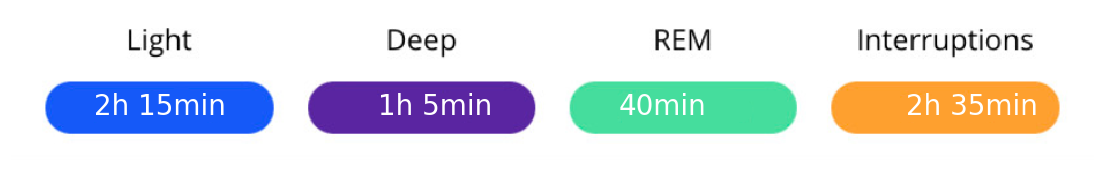

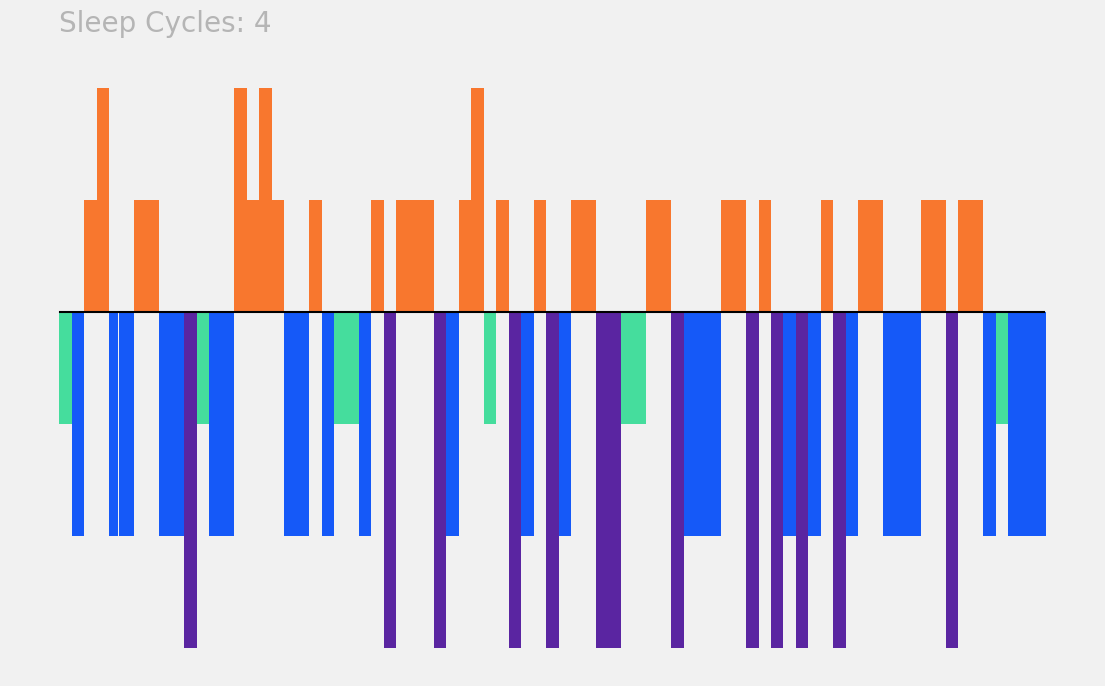

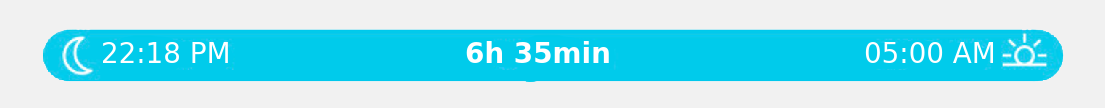

In [37]:
#@title Set date for the chart below

plot_date = "2022-05-12" #@param {type:"date"}


req_sleep = sleep_df[sleep_df.date==plot_date].iloc[0]
start_date = datetime.fromisoformat(req_sleep['sleepStartTime'])
hypnodata = req_sleep['sleepWakeStates']
sleep_hypnogram_altered = {}
sleep_hypnogram_altered_color = {}
master_color_key = {'1':'#F8772E','2':'#F8772E','-1':'#45DD9D','-2':'#1559F8','-3':'#5A25A1'}

time_dict = {0:0,
            1:0,
            2:0,
            3:0}

# Iterating through each key in timestamps except last
for i in range(len(hypnodata)-1):

    # Getting the current timestamp
    key = hypnodata[i]['offsetFromStart']
    
    key_str = str(start_date.timestamp()+int(key))

    # Getting the next timestamp
    next_key = hypnodata[i+1]['offsetFromStart']


    # Getting the current marking for the hypnogram
    value = hypnodata[i]['sleepWakeState']
    
    milli_seconds = int((int(next_key) - int(key)))
    time_dict[value] = time_dict[value] + milli_seconds 
        
    # t_val is the hypnogram value changed to suit our plot
    t_val = None

    # Value for Light Sleep
    if value == 2:
        sleep_hypnogram_altered[key_str] = -2
        t_val = -2

    # Value for Deep Sleep
    elif value == 3:
        sleep_hypnogram_altered[key_str] = -3
        t_val = -3

    # Value for REM
    elif value == 1:
        sleep_hypnogram_altered[key_str] = -1
        t_val = -1

    # Value for Interruptions
    else:
        if hypnodata[i]['longInterruption'] == True:
            # Longer interruptions
            sleep_hypnogram_altered[key_str] = 2
            t_val = 2
        else:
            sleep_hypnogram_altered[key_str] = 1
            t_val = 1

    # Key to be changed in order to get all the 
    # keys between the concurrent timestamps
    test_key = key

    # Setting color for the main timestamp
    sleep_hypnogram_altered_color[key_str] = master_color_key[str(t_val)]

    # Setting the color and t_val for the test_key
    sleep_hypnogram_altered[key_str] = t_val
    sleep_hypnogram_altered_color[key_str] = master_color_key[str(t_val)]
    for s in range(milli_seconds):
        key_str = str(start_date.timestamp()+int(key)+s)
         # Setting color for the main timestamp
        sleep_hypnogram_altered_color[key_str] = master_color_key[str(t_val)]
        # Setting the color and t_val for the test_key
        sleep_hypnogram_altered[key_str] = t_val
        sleep_hypnogram_altered_color[key_str] = master_color_key[str(t_val)]

from urllib.request import urlopen
from PIL import Image


# Creating the header figure
# Creating the header
header = plt.figure(figsize=(14,8), facecolor='white')
header_ax = header.gca()
header_ax.set_facecolor('white')

# Removing x and y ticks for the header
plt.xticks([],[])
plt.yticks([],[])

# Plotting header background image
header_img = Image.open(urlopen('https://i.imgur.com/2I4TxYH.png'))
plt.imshow(header_img,  interpolation='nearest')

# Removing the spines on top, left and right
header_ax.spines['top'].set_visible(False)
header_ax.spines['right'].set_visible(False)
header_ax.spines['left'].set_visible(False)
header_ax.spines['bottom'].set_visible(False)

# Function to convert seconds into the time format used in Polar Flow headers
def secondsconverter(secs):
    if secs//3600 == 0:
        return str(int(np.ceil(secs/60)))+'min'
    else:
        return (str(int(np.floor(secs/3600)))+'h '+
            str(int(np.ceil((secs%3600)/60)))+'min')

def time_setter(test_date):
    if int(test_date.split(':')[0]) > 12:
        return test_date + ' PM'
    else:
        return test_date+' AM'

# Displaying header information
plt.text(0.765,0.4575,secondsconverter(time_dict[0]),
        transform=header.transFigure,fontsize=20,color='white')
plt.text(0.56,0.4575,secondsconverter(time_dict[1]),
        transform=header.transFigure,fontsize=20,color='white')
plt.text(0.3875,0.4575,secondsconverter(time_dict[3]),
        transform=header.transFigure,fontsize=20,color='white')
plt.text(0.185,0.4575,secondsconverter(time_dict[2]),
        transform=header.transFigure,fontsize=20,color='white')

# Creating the plot figure
plt2 = plt.figure(figsize=(14,8), facecolor='#F1F1F1')
ax = plt2.gca()
ax.set_facecolor('#F1F1F1')

# Removing xticks and yticks
plt.xticks([],[])
plt.yticks([],[])

# Removing the spines on top, left and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Creating the sleep cycle text
plt.text(0,2.5,'Sleep Cycles: '+str(req_sleep['sleepCycles']), fontsize=20,
     color='#B5B5B5')
#Setting x-axis to black
plt.axhline(y = 0, color = 'black', linestyle = '-',xmin = 0.046, xmax = 0.953)

# Plotting the bar chart
plt.bar(list(sleep_hypnogram_altered.keys()),
        list(sleep_hypnogram_altered.values()),width=1,
        color=sleep_hypnogram_altered_color.values())

# Adding bottom bar to plot in a seprate chart
# insert path of the image.
b_bar_img = Image.open(urlopen('https://i.imgur.com/RMsObxL.png'))
b_bar = plt.figure(figsize = (14,2), facecolor='#F1F1F1')
ax2 = b_bar.gca()
ax2.set_facecolor('#F1F1F1')

# Plotting the image
plt.imshow(b_bar_img,  interpolation='nearest')

# Removing xticks and yticks
plt.xticks([],[])
plt.yticks([],[])

# Adding text for start and end time
start_time =  req_sleep['sleepStartTime'].split('T')[1][:5]
plt.text(0.19,0.45,time_setter(start_time),transform=b_bar.transFigure,
         color='white',fontsize=20)
end_time =  req_sleep['sleepEndTime'].split('T')[1][:5]
plt.text(0.735,0.45,time_setter(end_time),transform=b_bar.transFigure,
         color='white',fontsize=20)

# Adding text for total time
total_sleep_secs = sum(list(time_dict.values()))
total_time_str = (str(int(np.floor(total_sleep_secs/3600)))+'h '+
                  str(int(np.ceil((total_sleep_secs%3600)/60)))+'min')
plt.text(0.45,0.45,total_time_str,transform=b_bar.transFigure,
         color='white',fontsize=20,fontweight=800)

# Removing the spines on top, left and right
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

plt.show()

*^ Above is the plot that we created ourselves!*

## 7.2 Visualizing Weekly Sleep Summary

Along with the detailed sleep breakdown, our Polar Vantage also provides information on weekly sleep breakdown. For our next plot, let's recreate the following plot from the Polar Flow app.

<img src='https://i.imgur.com/jog0iGJ.jpg' width='600px'>

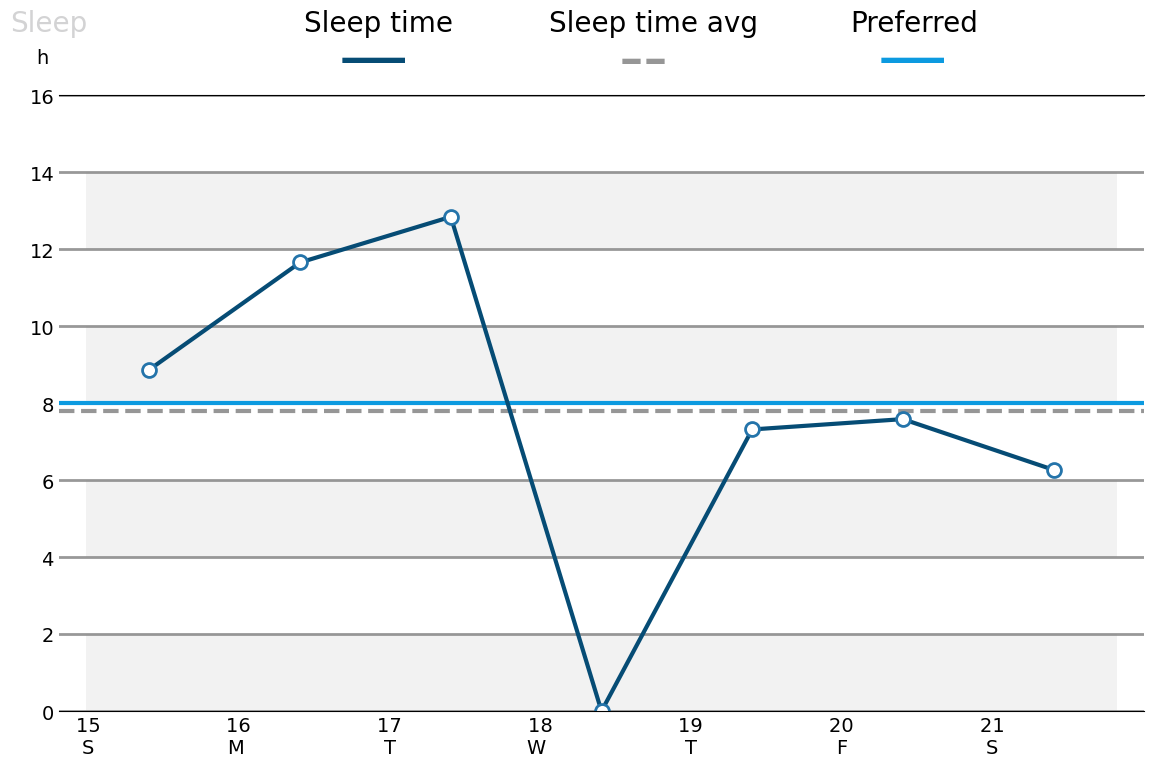

In [38]:
#@title Set date for the chart below

plot_date = "2022-05-15" #@param {type:"date"}

start_date = datetime.strptime(plot_date, '%Y-%m-%d')
end_date = start_date + timedelta(6)
end_date_str = str(end_date.year)+'-'+str(end_date.month)+'-'+str(end_date.day)
weekly_dates_list = []
xticks = []
for i in pd.date_range(start_date,end_date,freq='d'):
    weekly_dates_list.append(str(i)[:10])
    test_date = datetime.strptime(str(i)[:10], '%Y-%m-%d')
    xticks.append(str(test_date.day)+'        \n'+
                test_date.strftime("%A")[0]+'         ')
value_dict = {}
goals = []
for date in weekly_dates_list:
    res = sleep_df[sleep_df['date'] == date]
    if len(res)>0:
        duration = float(datetime.fromisoformat(res.iloc[0]['sleepEndTime'][:19]).timestamp()) - float(datetime.fromisoformat(res.iloc[0]['sleepStartTime'][:19]).timestamp())
        value_dict[date] = duration/3600
    else:
        value_dict[date] = 0
    goals.append(8)
# Creating the figure
plt3 = plt.figure(figsize=(14,8))
ax = plt3.gca()

# Adding grid to the plot
plt.grid(axis = 'y',color="#7F7F7F", linestyle='-', linewidth=2,alpha=0.8)

# Adding the color lines to grid
for (x,y) in [(0,2),(4,6),(8,10),(12,14)]:
    for i in np.arange(x, y):
        plt.axhspan(i, i+1, facecolor='#F2F2F2', alpha=1,
                xmin = 0.025, xmax = 0.975)


# Plotting line for preferred sleep
plt.axhline(np.mean(goals),color='#0C9AE0',lw=3)

# Plotting line for average sleep
plt.axhline(np.mean(list(value_dict.values())), linestyle='--',
            color='#969696',lw=3)

# Plotting the values
plt.plot(list(value_dict.keys()),list(value_dict.values()), 
         color='#064C75',lw=3)

# Removing margins on left and right of the plot
plt.margins(y=0,x=0.1)



# Highlighting single data points
for x,y in value_dict.items():
    plt.plot(x, y, marker="o", markersize=10,
    markeredgecolor="#2474AA",markerfacecolor="white", markeredgewidth=2)


# Removing the spines on left and right
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Modifying our x and y ticks
plt.yticks([0,2,4,6,8,10,12,14,16],fontsize=14)
plt.xticks(list(value_dict.keys()),xticks,ha='right',fontsize=14)
ax.tick_params(axis=u'both', which=u'both',length=0)

# Adding header text
plt.text(0.09,0.96,'Sleep', transform=plt3.transFigure,
         color='#D3D3D4',fontsize=20)
plt.text(0.109,0.92,'h', transform=plt3.transFigure,
         color='black',fontsize=14)

plt.text(0.3,0.96,'Sleep time', transform=plt3.transFigure,
         color='black',fontsize=20)
plt.text(0.325,0.9,'—', transform=plt3.transFigure,
         color='#064C75',fontsize=50)

plt.text(0.475,0.96,'Sleep time avg', transform=plt3.transFigure,
         color='black',fontsize=20)
plt.text(0.525,0.9,'--', transform=plt3.transFigure,
         color='#969696',fontsize=50)

plt.text(0.69,0.96,'Preferred', transform=plt3.transFigure,
         color='black',fontsize=20)
plt.text(0.71,0.9,'—', transform=plt3.transFigure,
         color='#0C9AE0',fontsize=50)

plt.show()

# 8. Data Analysis

According to a [course](https://www.uh.edu/class/ctr-public-history/tobearfruit/__docs/curriculum/ms/science/conxnbetwrespandhrtrate/lessonplan_conxnbetwrespandhrtrate.pdf) taught at the University of Huston, "The more the heart beats, the more breathing occurs. As the heart beats faster, it uses more energy and sends more oxygen to the body. If a person is exercising the oxygen is used very quickly in order to provide the muscles with needed energy to move."

**Our test hypothesis will be that Heart Rate and Calories Burned are correlated.**

In this portion of the notebook, we will be testing this exact hypothesis using the data that we fetched from the Polar Vantage 3.

First, let's get the required data from the training_history_df dataframe

In [39]:
test_data = training_history_df.get(['calories','hrAvg'])
test_data.head()

,calories,hrAvg
0,422,149
1,587,179
2,470,98
3,329,114
4,251,156


Let's create a quick plot on this to see if there is a correlation between these two values.

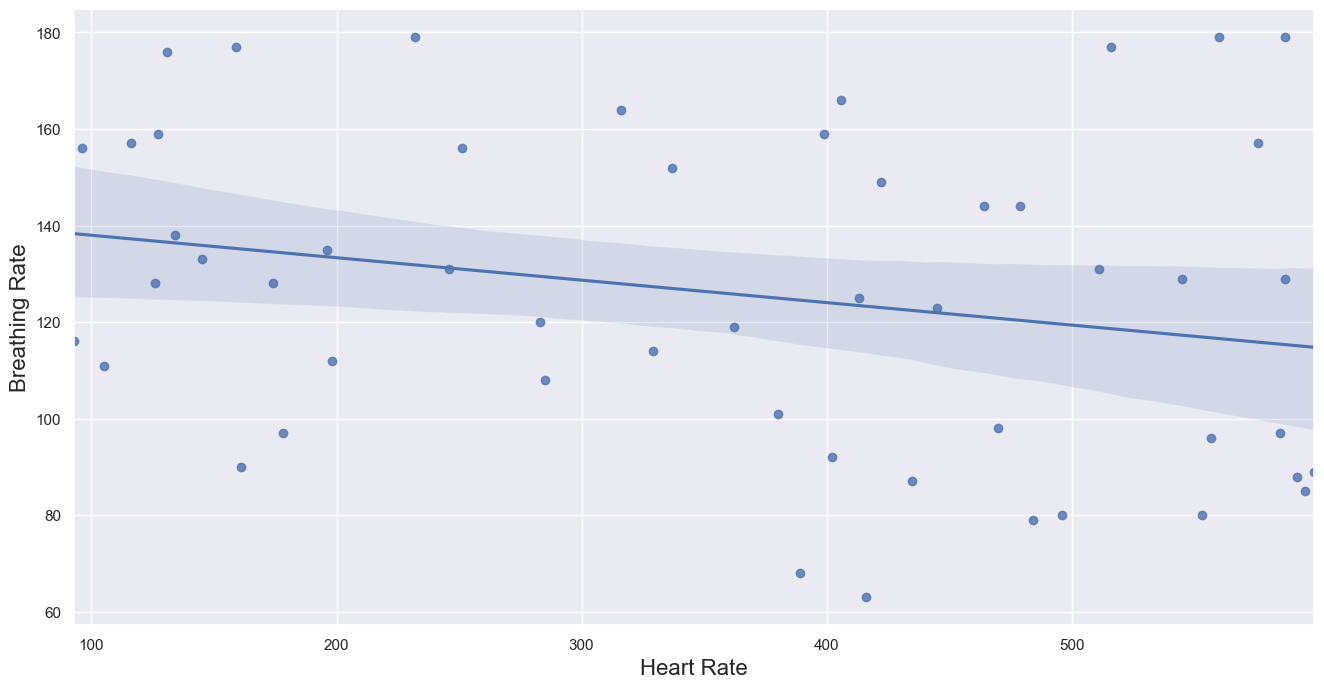

In [40]:
# Setting Figure Size in Seaborn
sns.set(rc={'figure.figsize':(16,8)})

# Setting Seaborn plot style
sns.set_style("darkgrid")

#Plotting our data
plot = sns.regplot(data=test_data, x='calories', y="hrAvg")

#Renaming x and y labels
plot.set_ylabel("Breathing Rate", fontsize = 16)
plot.set_xlabel("Heart Rate", fontsize = 16)

print()

Looking at the graph, we can see a line of regression which hints that Breathing and Heart Rate are directly correlated. However, there seems to be too much variability in the data. In the next line, we will prove this statistically.

In [41]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    test_data.get('calories'), test_data.get('hrAvg'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -0.0465
Coefficient of determination: 0.0573
p-value: 0.0875


The p-value for this is 0.875% which is much smaller than the 5% cutoff. This means that there is enough evidence to convincingly conclude that that there is a correlation between Avg Heart Rate and Calories Burned.

# 9. Outlier Detection

However, even though our P value seems to provide enough statistical significance that there is a correlation between Avg Heart Rate and Calories Burned, there might be outliers that are not following this correlation. In this section of our analysis, we will find if there are outliers like that and if they exist, we will visually highlight them in our plot.

Before finding the individual outlier values, it would be interesting to see the summary of our Avg heart Rate and Calories Consumed. It will give us a clear idea of what values are typical and which values can be considered atypical based on the data that we recieved from Cronometer.

In [42]:
test_data.describe()

,calories,hrAvg
count,52.000000,52.000000
mean,358.519231,125.961538
std,168.353327,32.717424
min,93.000000,63.000000
25%,191.500000,97.000000
50%,394.000000,128.000000
75%,499.750000,156.000000
max,599.000000,179.000000


To locate the outliers we will be using a supervised as well as unsupervised algorithm called the Elliptic Envelope. In statistical studies, Elliptic Envelope created an imaginary elliptical area around a given dataset where values inside that imaginary area is considered to be normal data, and anything else is assumed to be outliers. It assumes that the given Data follows a gaussian distribution.

"The main idea is to define the shape of the data and anomalies are those observations that lie far outside the shape. First a robust estimate of covariance of data is fitted into an ellipse around the central mode. Then, the Mahalanobis distance that is obtained from this estimate is used to define the threshold for determining outliers or anomalies." [(S. Shriram and E. Sivasankar ,2019, pp. 221-225)](https://ieeexplore.ieee.org/document/9004325)

In [43]:
# Sometimes EllipticEnvelope shows slicing based copy warnings
# The next line changes a setting that prevents the error from happening

pd.set_option('mode.chained_assignment', None)

#create the model, set the contamination as 0.02
EE_model = EllipticEnvelope(contamination = 0.02)

#implement the model on the data
outliers = EE_model.fit_predict(test_data.get(['calories','hrAvg']))

#extract the labels
test_data["outlier"] = copy.deepcopy(outliers)

#change the labels
# We use -1 to mark an outlier and +1 for an inliner
test_data["outlier"] = test_data["outlier"].apply(
                                    lambda x: str(-1) if x == -1 else str(1))

#extract the score
test_data["EE_scores"] = EE_model.score_samples(
                      test_data.get(['calories','hrAvg']))

#print the value counts for inlier and outliers
print(test_data["outlier"].value_counts())

1     50
-1     2
Name: outlier, dtype: int64


Below we will replot the test_data dataframe to see how the two new columns were applied to it!

In [44]:
test_data.head()

,calories,hrAvg,outlier,EE_scores
0,422,149,1,-0.827521
1,587,179,-1,-5.973359
2,470,98,1,-0.971247
3,329,114,1,-0.211004
4,251,156,1,-1.049277



Now that we have labeled the outliers as -1, let's try to see which values of average heart rate and calories are being identified as outliers by our Elliptic Envelope Algorithm.

In [45]:
outlier_df = test_data[test_data.get('outlier')=='-1'].get(
    ['calories','hrAvg'])
outlier_df_cleaned = outlier_df.drop_duplicates()
outlier_df_cleaned

,calories,hrAvg
1,587,179
5,560,179


Sweet, now that we know that there were outliers in our dataset, let's try to visually see which pair of values are being identified as outliers using a plot. Highlighting these outliers in a bright red color will make it super easy for us to identify them in our plot.

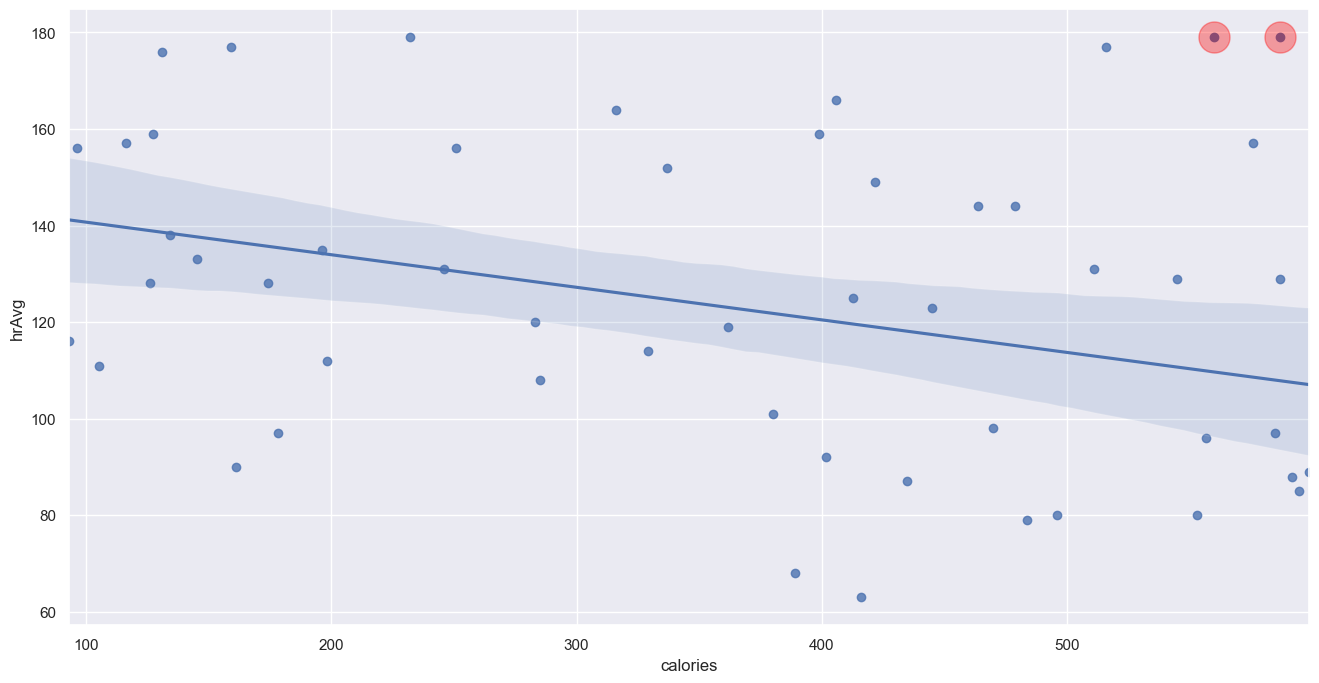

In [46]:
# Setting Figure Size in Seaborn
sns.set(rc={'figure.figsize':(16,8)})

# Setting Seaborn plot style
sns.set_style("darkgrid")

#Plotting our data
plot = sns.regplot(x='calories', y='hrAvg', data=test_data.drop(
    outlier_df.index))

plt.scatter(outlier_df_cleaned.get('calories'),outlier_df_cleaned.get('hrAvg'))
plt.scatter(outlier_df_cleaned.get('calories'),outlier_df_cleaned.get('hrAvg'),
            facecolors='red',alpha=.35, s=500)

plt.show()

Thus, the points highlighted in red are ones that seem to not be following the general trend of our dataset. Lastly, let's see what the new p-value is after outlier removal!

In [47]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    test_data.drop(outlier_df.index).get('calories'),
     test_data.drop(outlier_df.index).get('hrAvg'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: -0.0674
Coefficient of determination: 0.126
p-value: 0.0115


The p-value for this is 0.0115 which is much smaller than the 5% cutoff. This means that there is enough evidence to convincingly conclude that that there is a correlation between Heart Rate and Calories Burned.